In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import scipy

torch.manual_seed(0)

In [2]:
# Create a set of data and assign coresponding label that linearly
# depend with it.
X = torch.arange(0, 1, 0.02, device="cuda").unsqueeze(dim=1)
y = 0.7 * X + 0.3

# Split train, test set
train_amount = 0.8
train_set_length = int(train_amount*len(X))

X_train, X_test = X[:train_set_length], X[train_set_length:]
y_train, y_test = y[:train_set_length], y[train_set_length:]

In [3]:
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,      
):
    train_data = train_data.cpu()
    test_data = test_data.cpu()
    train_labels = train_labels.cpu()
    test_labels = test_labels.cpu()
    predictions = predictions.cpu() if predictions is not None else None

    plt.figure(figsize=(10,7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test dât in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predicts data")

    # Show legend
    plt.legend(prop={"size": 14})

In [ ]:
plot_predictions()

In [4]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float, device="cuda"))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float, device="cuda"))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [5]:
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([-0.9247], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.1808], device='cuda:0', requires_grad=True)]

In [6]:
epochs = 600

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

history = []
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train()
    # 1. Forward
    y_pred = model_0(X_train)
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    # 3. Perform backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Set the model to evaluating mode
    model_0.eval()

    if epoch % 10 == 0:
        with torch.inference_mode():
            test_loss = loss_fn(model_0(X_test), y_test)
        history.append((epoch, loss.item(), test_loss.item()))
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.752792477607727 | Test Loss: 1.5516527891159058
Epoch: 10 | Loss: 0.637582540512085 | Test Loss: 1.4169429540634155
Epoch: 20 | Loss: 0.5354046821594238 | Test Loss: 1.2903130054473877
Epoch: 30 | Loss: 0.45796918869018555 | Test Loss: 1.1783061027526855
Epoch: 40 | Loss: 0.4007486402988434 | Test Loss: 1.0804916620254517
Epoch: 50 | Loss: 0.357733815908432 | Test Loss: 0.9945837259292603
Epoch: 60 | Loss: 0.3260319232940674 | Test Loss: 0.920384407043457
Epoch: 70 | Loss: 0.3024834096431732 | Test Loss: 0.8564117550849915
Epoch: 80 | Loss: 0.28565841913223267 | Test Loss: 0.8022990226745605
Epoch: 90 | Loss: 0.27286437153816223 | Test Loss: 0.7557353973388672
Epoch: 100 | Loss: 0.26301082968711853 | Test Loss: 0.7155598998069763
Epoch: 110 | Loss: 0.25537562370300293 | Test Loss: 0.6818618178367615
Epoch: 120 | Loss: 0.24896256625652313 | Test Loss: 0.6520892977714539
Epoch: 130 | Loss: 0.24391646683216095 | Test Loss: 0.6275980472564697
Epoch: 140 | Loss: 0.2391885

In [16]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3060], device='cuda:0')),
             ('bias', tensor([0.4653], device='cuda:0'))])

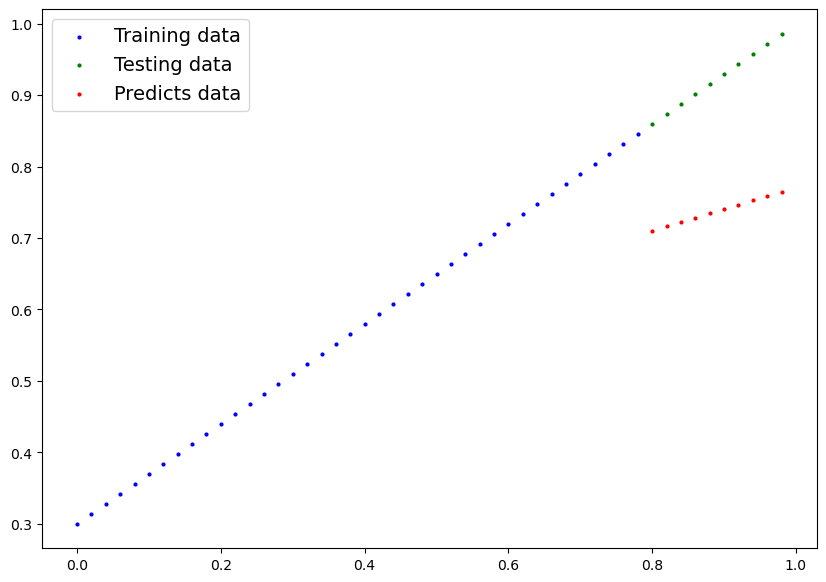

In [8]:
with torch.inference_mode():
    plot_predictions(predictions=model_0(X_test))

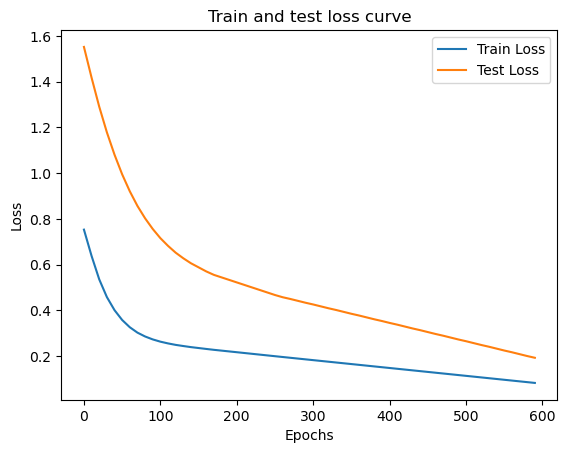

In [9]:
h = np.array(history)
plt.plot(h[:,0], h[:,1], label="Train Loss")
plt.plot(h[:,0], h[:,2], label="Test Loss")
plt.title("Train and test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [12]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_NAME = "model_0.pth"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

torch.save(model_0.state_dict(), (MODEL_PATH/MODEL_NAME))

In [14]:
new_model = LinearRegressionModel()
new_model.state_dict()

OrderedDict([('weights', tensor([-0.3452], device='cuda:0')),
             ('bias', tensor([0.2191], device='cuda:0'))])

In [15]:
new_model.load_state_dict(torch.load(MODEL_PATH/MODEL_NAME))
new_model.state_dict()

OrderedDict([('weights', tensor([0.3060], device='cuda:0')),
             ('bias', tensor([0.4653], device='cuda:0'))])